### Feature Extraction Pipeline for the PatternMind Dataset

In this cell, we implement the full feature-extraction pipeline used to convert raw images into numerical representations suitable for clustering and analysis. This is necessary because machine-learning models work on structured feature vectors rather than raw images.

We define a PatternMindFeatureExtractor class that performs the following steps:

1. Folder traversal:
   The script treats every subfolder inside the dataset directory as a separate class (e.g., *butterfly*, *rock*, *plane*).
   It automatically finds all images and counts them, giving us feedback about the number of images and categories.

2. Image preprocessing:
   For each image, the extractor:
   - Reads the file safely
   - Resizes it to 128×128 pixels
   - Ensures it has 3 color channels (RGB) even if the original is grayscale or has extra channels

3. Feature extraction (HOG + color histograms):
   - The image is converted to grayscale to compute HOG (Histogram of Oriented Gradients) features.
   - If enabled, a 24-dimensional RGB color histogram (8 bins per channel) is added to capture color information.
   - The final feature vector is a long 1-D numeric array that encodes shape + color characteristics.

4. Dataset assembly:
   All feature vectors are stacked together and combined with their corresponding labels into a Pandas DataFrame.
   You will see printed progress updates such as *"250/1000 images processed..."* and the final shape of the feature matrix.

5. Saving results:
   The DataFrame is saved to patternmind_features.csv, which becomes the input to the later clustering notebook.

When you run this cell, expect console output showing:
- Total images found
- Number of classes
- Progress through image processing
- The final feature matrix shape (e.g., (N_samples, N_features))
- A preview of the first few rows
- Confirmation that the CSV file has been saved

This step is essential because it transforms raw images into meaningful feature vectors used for the clustering analyses later in the notebook.

In [2]:
import os
import sys
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog


class PatternMindFeatureExtractor:
    def __init__(
        self,
        data_dir: str,
        output_csv: str = "patternmind_features.csv",
        img_size: Tuple[int, int] = (128, 128),
        use_color_hist: bool = True,
    ):
        """
        :param data_dir: Root folder (contains subfolders like butterfly / rock / plane / ...)
        :param output_csv: Name of the output CSV file
        :param img_size: Target size for resizing images
        :param use_color_hist: If True → HOG + color histogram, if False → only HOG
        """
        self.data_dir = data_dir
        self.output_csv = output_csv
        self.img_size = img_size
        self.use_color_hist = use_color_hist

    # ---------------------------------------------------
    # Folder traversal
    # ---------------------------------------------------
    def get_image_paths(self) -> List[Tuple[str, str]]:
        """
        Treat each subfolder under data_dir as a label,
        and each file inside as an image.

        Returns: list of (image_path, label_name)
        """
        image_paths: List[Tuple[str, str]] = []

        if not os.path.exists(self.data_dir):
            print(f"ERROR: Data folder not found: {self.data_dir}")
            sys.exit(1)

        for label_name in sorted(os.listdir(self.data_dir)):
            label_path = os.path.join(self.data_dir, label_name)
            if not os.path.isdir(label_path):
                # Skip if it’s a file, not a folder
                continue

            for fname in os.listdir(label_path):
                fpath = os.path.join(label_path, fname)
                if not os.path.isfile(fpath):
                    continue

                # Simple filter: image extensions
                if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                    continue

                image_paths.append((fpath, label_name))

        print(f"Total {len(image_paths)} images found.")
        print(f"Number of classes: {len(set(lbl for _, lbl in image_paths))}")
        return image_paths

    # ---------------------------------------------------
    # Feature extraction (HOG + RGB histogram)
    # ---------------------------------------------------
    def extract_features_for_image(self, img_path: str) -> Optional[np.ndarray]:
        """
        Extract features from a single image:
        - Read the image
        - Resize to img_size
        - Ensure 3-channel (RGB) format
        - Convert to grayscale and compute HOG features
        - Optionally add 3-channel color histogram (8 bins × 3 = 24)
        """
        try:
            img = imread(img_path)
        except Exception as e:
            print(f"Warning: could not read {img_path}: {e}")
            return None

        # If there is an alpha channel etc., keep only the first 3 channels
        if img.ndim == 3 and img.shape[2] > 3:
            img = img[:, :, :3]

        # If grayscale (2D) → copy into 3 channels
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=2)

        # Safety check: if still not 3 channels, skip
        if img.ndim != 3 or img.shape[2] != 3:
            print(f"Warning: unexpected shape for {img_path}: {img.shape}, skipping.")
            return None

        # Resize
        img_resized = resize(img, self.img_size, anti_aliasing=True)

        # Convert to grayscale for HOG
        gray = rgb2gray(img_resized)

        hog_features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            feature_vector=True,
        )

        if self.use_color_hist:
            # Always compute a 3-channel color histogram (8 bins × 3 = 24 features)
            hist_r, _ = np.histogram(
                img_resized[:, :, 0], bins=8, range=(0, 1), density=True
            )
            hist_g, _ = np.histogram(
                img_resized[:, :, 1], bins=8, range=(0, 1), density=True
            )
            hist_b, _ = np.histogram(
                img_resized[:, :, 2], bins=8, range=(0, 1), density=True
            )
            color_hist = np.concatenate([hist_r, hist_g, hist_b])
            features = np.concatenate([hog_features, color_hist])
        else:
            # Only HOG features
            features = hog_features

        return features

    # ---------------------------------------------------
    # Feature matrix for the whole dataset
    # ---------------------------------------------------
    def build_feature_dataset(self) -> pd.DataFrame:
        """
        Extract features from all images and return a DataFrame.

        Columns: f0, f1, ..., fN, label
        """
        image_paths = self.get_image_paths()

        all_features = []
        all_labels = []

        total = len(image_paths)
        for idx, (img_path, label_name) in enumerate(image_paths, start=1):
            if idx % 50 == 0 or idx == total:
                print(f"{idx}/{total} images processed...")

            feats = self.extract_features_for_image(img_path)
            if feats is None:
                continue

            all_features.append(feats)
            all_labels.append(label_name)

        if len(all_features) == 0:
            print("ERROR: No features could be extracted from any image.")
            sys.exit(1)

        X = np.vstack(all_features)
        y = np.array(all_labels)

        print(f"Feature matrix shape: {X.shape}")

        feature_cols = [f"f{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_cols)
        df["label"] = y

        return df

    # ---------------------------------------------------
    # Save as CSV
    # ---------------------------------------------------
    def save_to_csv(self) -> pd.DataFrame:
        """
        Run the full pipeline and save the final feature DataFrame to CSV.
        """
        df = self.build_feature_dataset()
        print("First 5 rows:")
        print(df.head())

        print(f"Saving CSV file: {self.output_csv}")
        df.to_csv(self.output_csv, index=False)
        print("Done.")
        return df


# ---------------------------------------------------
# MAIN
# ---------------------------------------------------

def main():
    print("PatternMind - Feature Extraction (Class) starting...")

    # ADJUST THIS PATH FOR YOUR MACHINE
    # Example:
    # data_dir = r"C:\Users\yourname\PycharmProjects\PatternMind_Project\PatternMind_Dataset"
    data_dir = r"PatternMind_Dataset"

    extractor = PatternMindFeatureExtractor(
        data_dir=data_dir,
        output_csv="patternmind_features.csv",
        img_size=(128, 128),
        use_color_hist=True,   # set to False if you only want HOG
    )

    extractor.save_to_csv()


if __name__ == "__main__":
    main()

PatternMind - Feature Extraction (Class) starting...
Total 25557 images found.
Number of classes: 233
50/25557 images processed...
100/25557 images processed...
150/25557 images processed...
200/25557 images processed...
250/25557 images processed...
300/25557 images processed...
350/25557 images processed...
400/25557 images processed...
450/25557 images processed...
500/25557 images processed...
550/25557 images processed...
600/25557 images processed...
650/25557 images processed...
700/25557 images processed...
750/25557 images processed...
800/25557 images processed...
850/25557 images processed...
900/25557 images processed...
950/25557 images processed...
1000/25557 images processed...
1050/25557 images processed...
1100/25557 images processed...
1150/25557 images processed...
1200/25557 images processed...
1250/25557 images processed...
1300/25557 images processed...
1350/25557 images processed...
1400/25557 images processed...
1450/25557 images processed...
1500/25557 images p

**Clustering and Analysis**

**This loads the PatternMind dataset, performs EDA, applies preprocessing and PCA, and evaluates mulptiple clustering methods to analyze hidden structure in the data.**

### Loading Dependencies and Preparing the Environment

In this cell, we begin by importing all the essential libraries required for our analysis. These include numerical and data-handling packages such as NumPy and Pandas, visualization tools like Matplotlib and Seaborn, and several machine-learning utilities from scikit-learn for preprocessing, dimensionality reduction, and clustering.

Next, we define the core configuration settings for the notebook, such as the dataset path, the name of the label column, and the directory where all generated figures will be stored. These parameters make the workflow flexible and easy to adapt to different datasets.

We also implement two helper functions:
- `ensure_images_dir()` — ensures that an output directory exists for saving plots.
- `load_dataset()` — loads the dataset from a CSV file, separates features and labels, and prints useful information about the dataset structure.

When this code is executed, you should expect:
- No figures yet, but printed output confirming the successful loading of the dataset.
- Information on the number of rows, columns, and which columns are treated as features or labels.
- Creation of an images/ directory if it does not already exist.

This setup cell prepares the environment for all subsequent analysis steps.

In [6]:
import os
import sys
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

# ==========================
# CONFIG
# ==========================


DATASET_PATH = "patternmind_features.csv"

LABEL_COLUMN = "label"

IMAGES_DIR = "images"


# ==========================
# HELPERS
# ==========================

def ensure_images_dir(path: str) -> None:
    """Create the images directory if it does not already exist."""
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)


def load_dataset(dataset_path: str, label_col: Optional[str]) -> Tuple[pd.DataFrame, List[str], Optional[np.ndarray]]:
    """
    Load the dataset from CSV, return:
    - full DataFrame
    - list of feature columns
    - label vector (y) if label_col is provided, otherwise None
    """
    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset path not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path)

    # If label column exists, separate it
    if label_col is not None and label_col in df.columns:
        y = df[label_col].values
        feature_cols = [c for c in df.columns if c != label_col]
    else:
        y = None
        feature_cols = list(df.columns)

    print("Dataset successfully loaded.")
    print("Total rows, columns:", df.shape)
    print("Number of feature columns:", len(feature_cols))
    if y is not None:
        print(f"Label column: {label_col}")
    else:
        print("No label column used (unsupervised only).")

    return df, feature_cols, y

In this cell, we perform a basic Exploratory Data Analysis (EDA) to understand the structure and distribution of our extracted feature dataset.
First, we compute descriptive statistics (mean, standard deviation, min/max values) for the feature columns to verify numerical consistency and detect any anomalies.
We also display the first few rows of the dataset so the reader can confirm that features and labels were loaded correctly.

If class labels are available, we additionally plot a label-distribution bar chart.
This figure allows us to visually inspect whether the dataset is balanced or skewed across categories, which is important because imbalanced classes can influence clustering and evaluation later.

In [7]:
def perform_eda(df: pd.DataFrame, feature_cols: List[str], y: Optional[np.ndarray]) -> None:
    """
    Basic Exploratory Data Analysis (EDA).
    Prints descriptive statistics and optionally label distribution.
    """
    print("\n--- Exploratory Data Analysis (EDA) ---")
    print(df[feature_cols].describe().T.head())

    # First 5 rows
    print("\nFirst 5 rows:")
    print(df[feature_cols + ([LABEL_COLUMN] if y is not None else [])].head())

    # Label distribution (if labels exist)
    if y is not None:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=y)
        plt.title("Label distribution")
        plt.xticks(rotation=45)
        plt.tight_layout()
        ensure_images_dir(IMAGES_DIR)
        plt.savefig(os.path.join(IMAGES_DIR, "label_distribution.png"), dpi=300)
        plt.show()

In this step, we apply a full preprocessing pipeline to prepare the feature matrix for clustering.
We begin by handling any missing values using mean imputation, ensuring that all features remain usable.
Next, we standardize the data with StandardScaler so that all features contribute equally regardless of their original scale—this is essential because PCA and distance-based clustering algorithms are sensitive to feature magnitude.

We then apply Principal Component Analysis (PCA) to reduce the feature space to two components.
Reducing the dimensionality helps us visualize the dataset and assess its structure while retaining as much variance as possible.
After computing PCA, we generate a scatter plot that places each sample in the new 2-dimensional space.
This figure shows how the data is distributed along the first two principal components, allowing us to visually anticipate cluster separability or overlap before applying any clustering method.

The second function provides a helper for producing PCA scatter plots colored by a chosen vector (e.g., labels or cluster assignments).
These colored PCA visualizations will later help us compare true labels—when available—with clustering results.

In [8]:
def preprocess_and_pca(
    df: pd.DataFrame,
    feature_cols: List[str],
    n_components: int = 2
) -> Tuple[np.ndarray, np.ndarray, StandardScaler, PCA]:
    """
    Basic preprocessing pipeline:
    - Mean imputation for missing values
    - StandardScaler for feature scaling
    - PCA for dimensionality reduction
    """
    print("\n--- Preprocessing & PCA ---")

    # Simple mean imputation
    X = df[feature_cols].copy()
    X = X.fillna(X.mean())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    explained = pca.explained_variance_ratio_.sum()
    print(f"PCA {n_components} components, explained variance ratio sum: {explained:.3f}")

    # PCA scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5)
    plt.title("PCA (first 2 components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    ensure_images_dir(IMAGES_DIR)
    plt.savefig(os.path.join(IMAGES_DIR, "pca_projection.png"), dpi=300)
    plt.show()

    return X_scaled, X_pca, scaler, pca


def plot_pca_colored(
    X_pca: np.ndarray,
    color_vec: np.ndarray,
    title: str,
    filename: str,
    legend_title: str = ""
) -> None:
    """
    Helper function to plot PCA (2D) with points colored by 'color_vec'.
    Optionally shows a legend based on the color mapping.
    """
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color_vec, s=5, cmap="tab20")
    if legend_title:
        # Legend can become very crowded; feel free to remove it if needed
        plt.legend(*scatter.legend_elements(), title=legend_title, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    ensure_images_dir(IMAGES_DIR)
    plt.savefig(os.path.join(IMAGES_DIR, filename), dpi=300)
    plt.show()

In this section, we evaluate and compare several clustering algorithms by running them on the preprocessed feature matrix.
We begin with K-Means, applying it over a range of cluster numbers.
For each value of *k*, we compute two widely used internal validation metrics: the Silhouette Score, which measures how well-separated clusters are, and the Davies–Bouldin Index, which quantifies cluster compactness and separation (lower is better).
The resulting table and printed metrics help us identify the most promising number of clusters.

After selecting the optimal *k*, we run K-Means again and visualize the resulting cluster assignments in the PCA-reduced 2D space.
This plot will show how well K-Means forms distinct groups and whether the chosen *k* produces meaningful structure.

Next, we apply hierarchical (agglomerative) clustering using three common linkage strategies: Ward, Average, and Complete.
Each method may produce different cluster shapes, so we evaluate them using the same metrics and visualize their PCA projections.
The user can compare these figures to understand how linkage choice affects cluster separation.

Finally, we fit a Gaussian Mixture Model (GMM), which assumes clusters follow multivariate Gaussian distributions and can capture more flexible cluster shapes than K-Means.
We again compute Silhouette and Davies–Bouldin scores and visualize the resulting assignments in PCA space.
These evaluations collectively allow us to compare multiple clustering paradigms and identify which model best captures the structure of the dataset.

In [9]:
def evaluate_kmeans(X_scaled: np.ndarray, k_values: List[int]) -> pd.DataFrame:
    """
    Run K-Means for different k values and compute evaluation metrics.
    Returns a DataFrame with silhouette and Davies-Bouldin scores.
    """
    print("\n--- K-Means Evaluation ---")
    results = []
    for k in k_values:
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        results.append({"k": k, "silhouette": sil, "davies_bouldin": db})
        print(f"k={k:2d}  Silhouette={sil:.4f}  Davies-Bouldin={db:.4f}")
    res_df = pd.DataFrame(results)
    return res_df


def run_kmeans_best(X_scaled: np.ndarray, X_pca: np.ndarray, best_k: int) -> np.ndarray:
    """
    Run K-Means with the selected k value and visualize clusters in PCA space.
    Returns cluster labels.
    """
    print(f"\n--- K-Means (k={best_k}) ---")
    km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
    cluster_labels = km.fit_predict(X_scaled)
    print("K-Means clustering completed.")

    plot_pca_colored(
        X_pca,
        cluster_labels,
        title=f"K-Means clusters (k={best_k}) in PCA space",
        filename=f"kmeans_pca_k{best_k}.png",
        legend_title="Cluster"
    )
    return cluster_labels


def run_hierarchical(X_scaled: np.ndarray, X_pca: np.ndarray, n_clusters: int) -> pd.DataFrame:
    """
    Run Agglomerative Clustering for different linkage methods and evaluate.
    Returns a DataFrame with silhouette and Davies-Bouldin scores for each linkage.
    """
    print("\n--- Hierarchical Clustering ---")
    linkages = ["ward", "average", "complete"]
    results = []
    for link in linkages:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=link)
        labels = agg.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        results.append({"linkage": link, "silhouette": sil, "davies_bouldin": db})
        print(f"linkage={link:8s}  Silhouette={sil:.4f}  Davies-Bouldin={db:.4f}")

        plot_pca_colored(
            X_pca,
            labels,
            title=f"Agglomerative ({link}) clusters (k={n_clusters})",
            filename=f"agg_{link}_k{n_clusters}.png",
            legend_title="Cluster"
        )

    return pd.DataFrame(results)


def run_gmm(X_scaled: np.ndarray, X_pca: np.ndarray, n_components: int) -> Tuple[np.ndarray, float, float]:
    """
    Run Gaussian Mixture Model (GMM) clustering and compute metrics.
    Returns cluster labels, silhouette score and Davies-Bouldin score.
    """
    print(f"\n--- Gaussian Mixture Models (n_components={n_components}) ---")
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    print(f"GMM  Silhouette={sil:.4f}  Davies-Bouldin={db:.4f}")

    plot_pca_colored(
        X_pca,
        labels,
        title=f"GMM clusters (k={n_components}) in PCA space",
        filename=f"gmm_k{n_components}.png",
        legend_title="Cluster"
    )

    return labels, sil, db

In this step, we evaluate how well the clustering results align with the true class labels of the dataset.
When labels are available, we compute two standard external validation metrics:

* Adjusted Rand Index (ARI): Measures similarity between cluster assignments and true labels, adjusted for chance. A value close to 1 indicates strong agreement.
* Normalized Mutual Information (NMI): Quantifies how much information is shared between clusters and labels. Higher values indicate better correspondence.

To complement these numerical scores, we also generate a contingency table heatmap showing the distribution of true labels inside each cluster.
Before viewing the figure, the reader should expect a grid where rows represent clusters and columns represent classes.
A good clustering will display clear block-like patterns, indicating that each cluster corresponds predominantly to a single label category.

This combined analysis helps determine how meaningful and label-aligned each clustering method is.

In [10]:
def cluster_label_analysis(
    clusters: np.ndarray,
    y: Optional[np.ndarray],
    method_name: str = "kmeans"
) -> None:
    """
    Analyse alignment between clusters and true labels (if available):
    - ARI (Adjusted Rand Index)
    - NMI (Normalized Mutual Information)
    - Contingency table (cluster vs label) as a heatmap
    """
    if y is None:
        print("\nNo labels available, skipping cluster-label analysis.")
        return

    print(f"\n--- Cluster vs Label Analysis ({method_name}) ---")

    # ARI & NMI
    ari = adjusted_rand_score(y, clusters)
    nmi = normalized_mutual_info_score(y, clusters)
    print(f"{method_name} ARI: {ari:.4f}")
    print(f"{method_name} NMI: {nmi:.4f}")

    # Contingency table
    ct = pd.crosstab(clusters, y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct, cmap="viridis")
    plt.xlabel("Label")
    plt.ylabel("Cluster")
    plt.title(f"Cluster vs Label ({method_name})")
    plt.tight_layout()
    ensure_images_dir(IMAGES_DIR)
    plt.savefig(os.path.join(IMAGES_DIR, f"cluster_label_heatmap_{method_name}.png"), dpi=300)
    plt.show()

In this step, we evaluate how well the clustering results align with the true class labels of the dataset.
When labels are available, we compute two standard external validation metrics:

* Adjusted Rand Index (ARI): Measures similarity between cluster assignments and true labels, adjusted for chance. A value close to 1 indicates strong agreement.
* Normalized Mutual Information (NMI): Quantifies how much information is shared between clusters and labels. Higher values indicate better correspondence.

To complement these numerical scores, we also generate a contingency table heatmap showing the distribution of true labels inside each cluster.
Before viewing the figure, the reader should expect a grid where rows represent clusters and columns represent classes.
A good clustering will display clear block-like patterns, indicating that each cluster corresponds predominantly to a single label category.

This combined analysis helps determine how meaningful and label-aligned each clustering method is.

In [11]:
def cluster_label_analysis(
    clusters: np.ndarray,
    y: Optional[np.ndarray],
    method_name: str = "kmeans"
) -> None:
    """
    Analyse alignment between clusters and true labels (if available):
    - ARI (Adjusted Rand Index)
    - NMI (Normalized Mutual Information)
    - Contingency table (cluster vs label) as a heatmap
    """
    if y is None:
        print("\nNo labels available, skipping cluster-label analysis.")
        return

    print(f"\n--- Cluster vs Label Analysis ({method_name}) ---")

    # ARI & NMI
    ari = adjusted_rand_score(y, clusters)
    nmi = normalized_mutual_info_score(y, clusters)
    print(f"{method_name} ARI: {ari:.4f}")
    print(f"{method_name} NMI: {nmi:.4f}")

    # Contingency table
    ct = pd.crosstab(clusters, y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(ct, cmap="viridis")
    plt.xlabel("Label")
    plt.ylabel("Cluster")
    plt.title(f"Cluster vs Label ({method_name})")
    plt.tight_layout()
    ensure_images_dir(IMAGES_DIR)
    plt.savefig(os.path.join(IMAGES_DIR, f"cluster_label_heatmap_{method_name}.png"), dpi=300)
    plt.show()

In this final cell, we integrate the full workflow of the project into a single executable pipeline.
The main steps of the analysis are performed sequentially:

1. Load the dataset and separate features from labels.
2. Run Exploratory Data Analysis, printing summary statistics and showing the class distribution.
3. Preprocess the data, applying mean imputation, scaling, and PCA, and visualizing the resulting 2-D projection.
4. Evaluate multiple K-Means configurations across a range of *k* values and summarise their silhouette and Davies–Bouldin scores.
   The notebook automatically selects the best *k* based on the highest silhouette score.
5. Run K-Means with the selected k and visualize the clusters in PCA space.
   If labels are available, we compare clusters to ground-truth using ARI, NMI, and a heatmap.
6. Apply hierarchical clustering with the same number of clusters to compare methods, including PCA-based visualizations.
7. Run a Gaussian Mixture Model (GMM) using the same number of components and again evaluate cluster–label alignment.

Running this cell will generate all figures (PCA scatter plots, cluster visualizations, heatmaps) and store them in the images directory. The console output summarizes the evaluation scores for each clustering algorithm, making it easy to compare their performance.

PatternMind Project pure Python (.py) starting...
Dataset successfully loaded.
Total rows, columns: (25557, 8125)
Number of feature columns: 8124
Label column: label

--- Exploratory Data Analysis (EDA) ---
      count      mean       std  min           25%       50%       75%  \
f0  25557.0  0.155516  0.135583  0.0  6.455961e-03  0.149502  0.251729   
f1  25557.0  0.074781  0.090348  0.0  0.000000e+00  0.038282  0.122396   
f2  25557.0  0.077723  0.092615  0.0  9.935730e-16  0.040686  0.128445   
f3  25557.0  0.082428  0.096148  0.0  0.000000e+00  0.045168  0.137398   
f4  25557.0  0.161746  0.141536  0.0  2.864525e-03  0.159469  0.260209   

         max  
f0  0.707107  
f1  0.614517  
f2  0.577350  
f3  0.563571  
f4  0.837439  

First 5 rows:
         f0        f1        f2        f3        f4        f5        f6  \
0  0.371718  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.482221  0.000000  0.000000  0.000000  0.001181  0.004121  0.004055   
2  0.440681  0.000

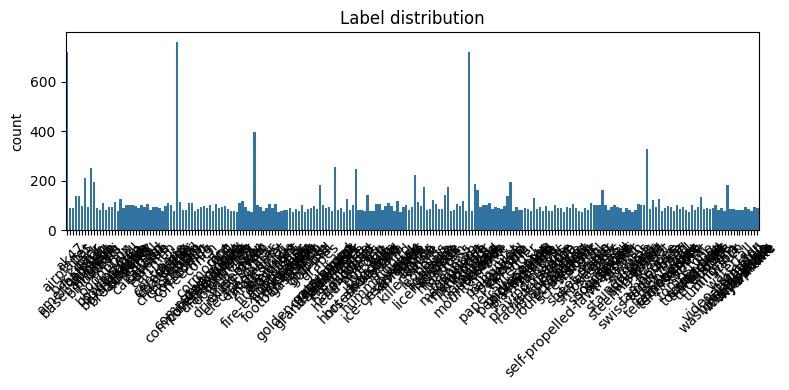


--- Preprocessing & PCA ---
PCA 2 components, explained variance ratio sum: 0.090


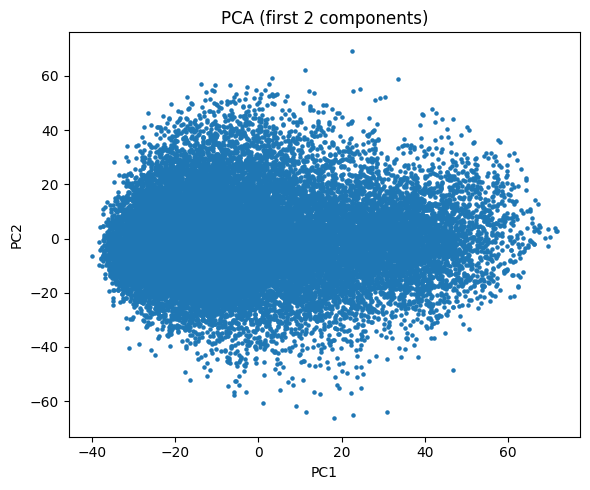


--- K-Means Evaluation ---
k= 5  Silhouette=0.0154  Davies-Bouldin=5.8237
k= 8  Silhouette=0.0118  Davies-Bouldin=5.3939
k=10  Silhouette=-0.0034  Davies-Bouldin=5.9293
k=12  Silhouette=0.0031  Davies-Bouldin=5.5170
k=15  Silhouette=-0.0062  Davies-Bouldin=5.6962

K-Means results table:
    k  silhouette  davies_bouldin
0   5    0.015383        5.823693
1   8    0.011823        5.393905
2  10   -0.003375        5.929255
3  12    0.003072        5.516976
4  15   -0.006171        5.696230

Automatically selected best k (based on silhouette): 5

--- K-Means (k=5) ---
K-Means clustering completed.


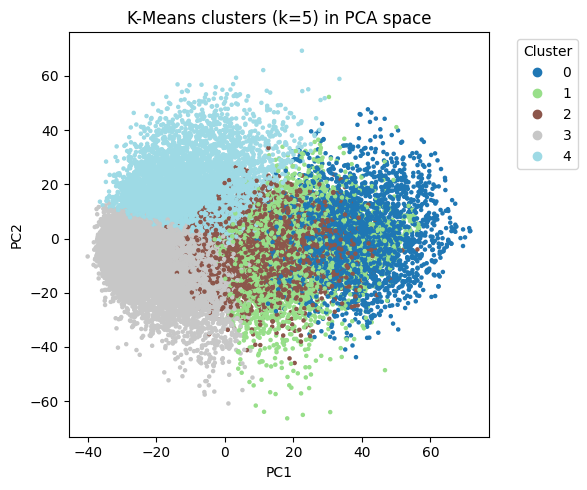


--- Cluster vs Label Analysis (kmeans) ---
kmeans ARI: 0.0111
kmeans NMI: 0.1108


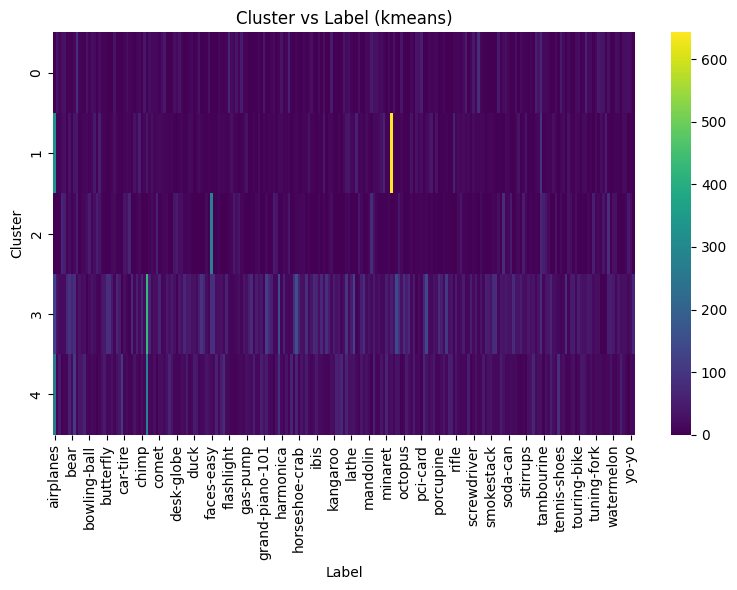


--- Hierarchical Clustering ---
linkage=ward      Silhouette=-0.0040  Davies-Bouldin=5.8944


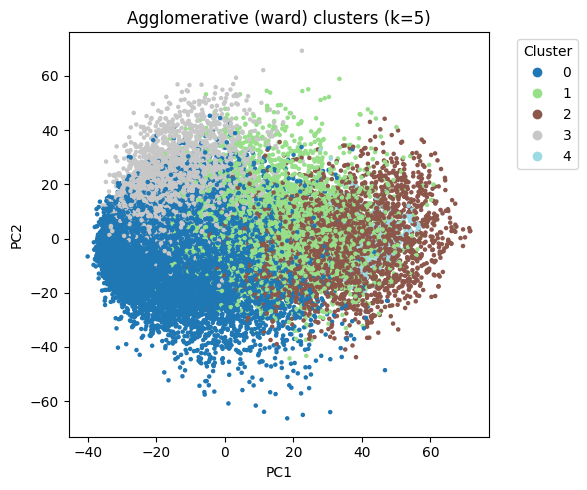

linkage=average   Silhouette=0.1513  Davies-Bouldin=1.1545


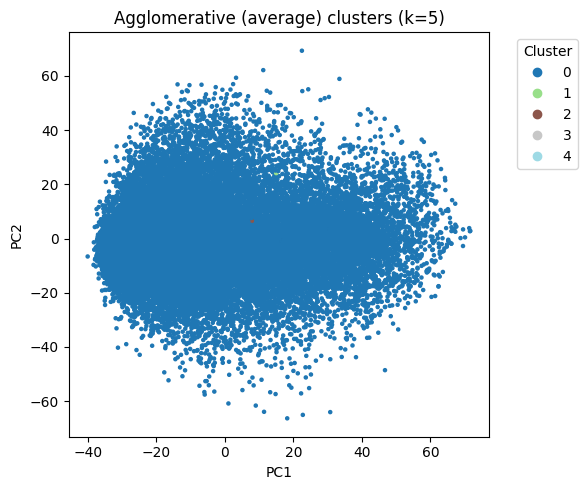

linkage=complete  Silhouette=0.0073  Davies-Bouldin=4.9129


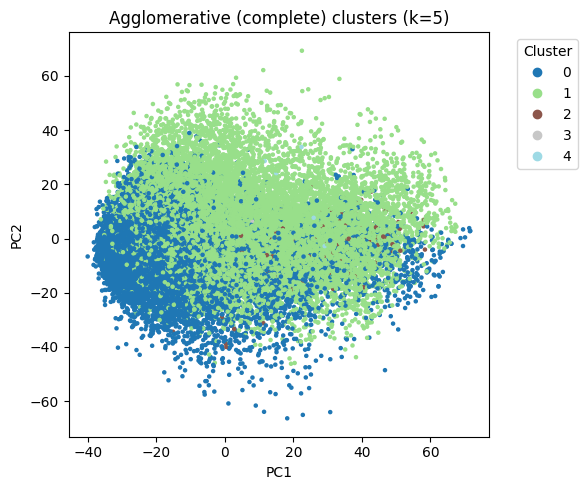


Hierarchical clustering results table:
    linkage  silhouette  davies_bouldin
0      ward   -0.003965        5.894442
1   average    0.151310        1.154457
2  complete    0.007258        4.912895

--- Gaussian Mixture Models (n_components=5) ---
GMM  Silhouette=0.0154  Davies-Bouldin=5.8237


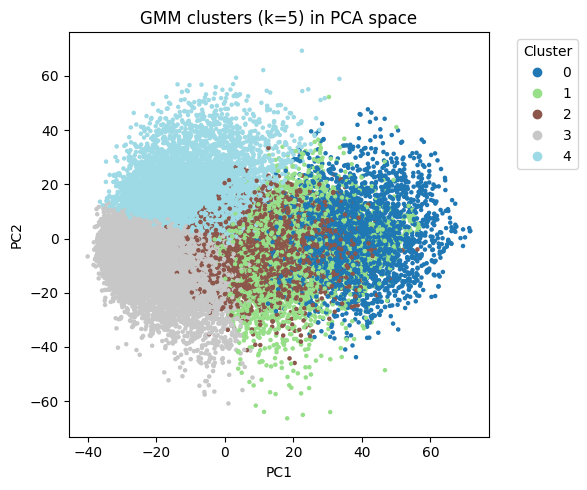


--- Cluster vs Label Analysis (gmm) ---
gmm ARI: 0.0111
gmm NMI: 0.1108


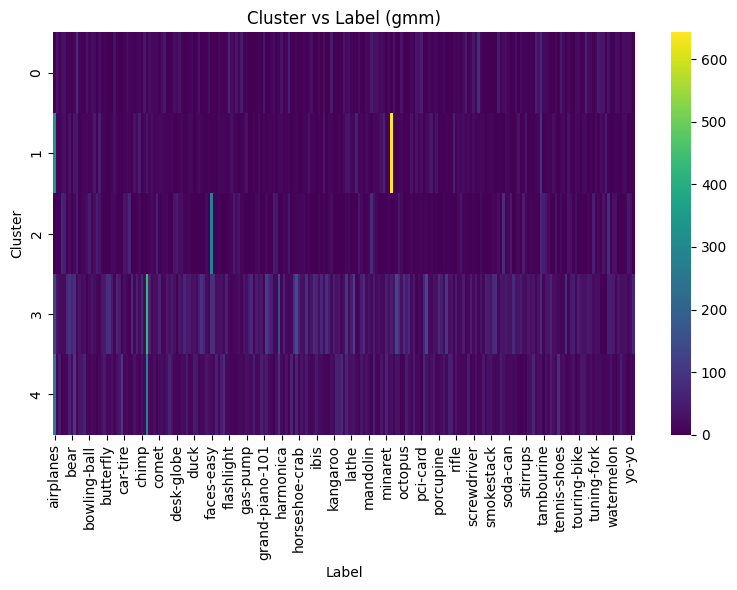


ALL ANALYSES COMPLETED.
Figures saved in 'images' directory. Don't forget to interpret the outputs in your README!


In [12]:
def main():
    print("PatternMind Project pure Python (.py) starting...")

    # 1) Load dataset
    df, feature_cols, y = load_dataset(DATASET_PATH, LABEL_COLUMN)

    # 2) EDA
    perform_eda(df, feature_cols, y)

    # 3) Preprocessing + PCA
    X_scaled, X_pca, scaler, pca = preprocess_and_pca(df, feature_cols, n_components=2)

    # 4) K-Means: choose range of k values
    k_values = [5, 8, 10, 12, 15]   # Feel free to change this list
    km_eval_df = evaluate_kmeans(X_scaled, k_values)
    print("\nK-Means results table:")
    print(km_eval_df)

    # !!! YOU decide here: which k will you pick?
    # Example: highest silhouette or lowest Davies-Bouldin
    best_k = int(km_eval_df.sort_values("silhouette", ascending=False).iloc[0]["k"])
    print(f"\nAutomatically selected best k (based on silhouette): {best_k}")

    # 5) Run final K-Means with chosen k + cluster-label analysis
    kmeans_clusters = run_kmeans_best(X_scaled, X_pca, best_k)
    cluster_label_analysis(kmeans_clusters, y, method_name="kmeans")

    # 6) Hierarchical clustering with the same k
    hier_eval_df = run_hierarchical(X_scaled, X_pca, n_clusters=best_k)
    print("\nHierarchical clustering results table:")
    print(hier_eval_df)

    # 7) GMM clustering
    gmm_clusters, gmm_sil, gmm_db = run_gmm(X_scaled, X_pca, n_components=best_k)
    cluster_label_analysis(gmm_clusters, y, method_name="gmm")

    print("\nALL ANALYSES COMPLETED.")
    print(f"Figures saved in '{IMAGES_DIR}' directory. Don't forget to interpret the outputs in your README!")


if __name__ == "__main__":
    main()